## Final Project Audit IT
### Concept Drift Detection 

- Sliding Window Technique: Implement a sliding window approach to process the event log in chunks.
- Conformance Checking: Use conformance metrics like fitness and precision to evaluate the alignment of current traces with the process model.
- Regression Analysis: Apply regression analysis on conformance metrics to detect significant changes.

### Utilizing GPU with Tensorflow

In [2]:
# install a virtual environment

!python3 -m venv ~/venv-tfmetal
!source ~/venv-tfmetal/bin/activate
!python3 -m pip install -U pip

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!python3 -m pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# install the Apple metal add-on for TensorFlow:
!python3 -m pip install tensorflow-metal

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# verify that TensorFlow will utilize the GPU

import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("Using GPU with this details: ", details)

/Users/hanna/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU with this details:  {'device_name': 'METAL'}


#### Installing Required Libraries

In [6]:
pip install pm4py pandas matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### Preparing the Dataset
I'm using Travel Permit Dataset from BPI Challenge 2020 https://data.4tu.nl/datasets/db35afac-2133-40f3-a565-2dc77a9329a3 which contains the events related to travel permits (including all related events of relevant prepaid travel cost declarations and travel declarations): 7,065 cases, 86,581 events

In [7]:
import pm4py

log = pm4py.read_xes('Dataset/PermitLog.xes')

/Users/hanna/Library/Python/3.9/lib/python/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/Users/hanna/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 7065/7065 [00:03<00:00, 2301.23it/s]


In [8]:
# Convert the event log to a DataFrame
from pm4py.objects.conversion.log import converter as log_converter

df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

# Display the first few rows of the DataFrame
print(df.head())

                         id  org:resource  \
0  rv_travel permit 76455_6  STAFF MEMBER   
1  rv_travel permit 76455_7  STAFF MEMBER   
2           st_step 76459_0  STAFF MEMBER   
3           st_step 76460_0  STAFF MEMBER   
4           st_step 76461_0  STAFF MEMBER   

                          concept:name            time:timestamp    org:role  \
0                           Start trip 2016-10-05 00:00:00+00:00    EMPLOYEE   
1                             End trip 2016-10-05 00:00:00+00:00    EMPLOYEE   
2         Permit SUBMITTED by EMPLOYEE 2017-04-06 13:32:10+00:00    EMPLOYEE   
3  Permit FINAL_APPROVED by SUPERVISOR 2017-04-06 13:32:28+00:00  SUPERVISOR   
4    Declaration SUBMITTED by EMPLOYEE 2017-04-07 13:38:14+00:00    EMPLOYEE   

   case:OrganizationalEntity case:ProjectNumber case:TaskNumber  \
0  organizational unit 65458            UNKNOWN         UNKNOWN   
1  organizational unit 65458            UNKNOWN         UNKNOWN   
2  organizational unit 65458            UNKNOWN

Kali ini kita akan menggali lebih dalam tentang dataset yang kita gunakan dengan mencari: </br>
- **Jumlah Events**: Jumlah total event pada event log yang dihitung dari jumlah total baris pada df (DataFrame)
- **Jumlah Cases**: Jumlah process instances (cases) yang unik pada event log yang dihitung dari nilai unik yang ada pada kolom 'case:concept:name'
- **Start Activities**: Activities yang muncul pertama kali pada process instances
- **End Activities**: Activities yang muncul terakhir kali pada process instances

In [8]:
# Calculate the number of events and cases in the event log
num_events = len(df)
num_cases = df['case:concept:name'].nunique()

# Format the DataFrame to be compatible with PM4Py
event_log = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')

# Identify the start and end activities in the process
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

print("Number of events: {}\nNumber of cases: {}".format(num_events, num_cases))
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))


Number of events: 86581
Number of cases: 7065
Start activities: {'Permit SUBMITTED by EMPLOYEE': 6319, 'Start trip': 734, 'Permit SAVED by EMPLOYEE': 12}
End activities: {'Payment Handled': 5474, 'Send Reminder': 991, 'End trip': 453, 'Permit REJECTED by EMPLOYEE': 31, 'Permit FINAL_APPROVED by SUPERVISOR': 14, 'Declaration SAVED by EMPLOYEE': 28, 'Permit SAVED by EMPLOYEE': 4, 'Declaration REJECTED by EMPLOYEE': 28, 'Request Payment': 1, 'Declaration REJECTED by SUPERVISOR': 1, 'Permit REJECTED by MISSING': 38, 'Declaration REJECTED by MISSING': 2}


Mari kita visualisasikan dsitribusi aktivitas dari event log. Didapati bahwa frekuensi tertinggi ada pada submission, payment handling, dan request payment yang menunjukkan bahwa tiga aktivitas ini merupakan initi dari proses bisnis. Selain itu ada banyak aktivitas approval yang menunjukkan banyaknya validasi dan checking dalam tiap tahap pada proses bisnis.

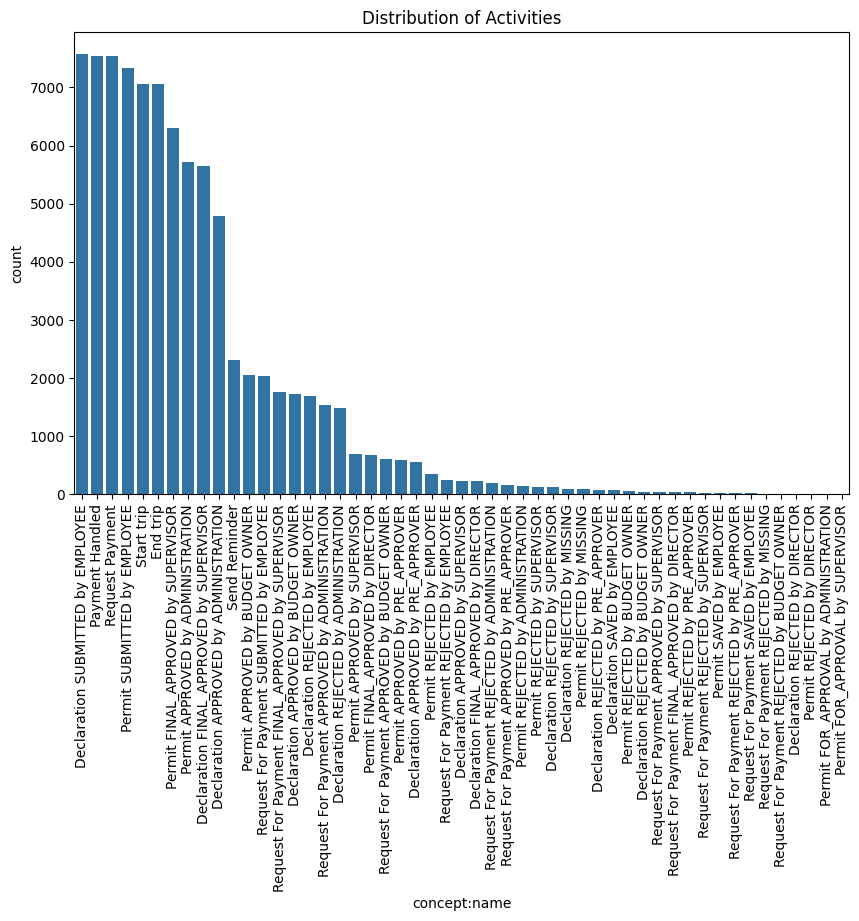

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='concept:name', order=df['concept:name'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Activities')
plt.show()

#### Random Sampling 50% of the Original Dataset
Setelah dilakukan percobaan menggunakan dataset original dengan jumlah yang besar, dibutuhkan waktu yang lama untuk melakukan Conformance Checking, sehingga kita gunakan 50% nya dulu

In [9]:
import pandas as pd

# Randomly sample 50% of the cases
sampled_cases = df['case:concept:name'].drop_duplicates().sample(frac=0.5, random_state=42)
sampled_df = df[df['case:concept:name'].isin(sampled_cases)]
print(f"Sampled number of cases: {sampled_df['case:concept:name'].nunique()}")
print(f"Sampled number of events: {len(sampled_df)}")

Sampled number of cases: 3532
Sampled number of events: 43267


#### Convert Sampled DataFrame back to Event Log

In [12]:
sampled_log = pm4py.convert_to_event_log(sampled_df)

#### Data Preprocessing

In [13]:
# Check for missing values
print(sampled_df.isnull().sum())

id                    0
org:resource          0
concept:name          0
time:timestamp        0
org:role              0
                  ...  
case:Task_4       42796
case:Task_9       43108
case:Task_8       43108
case:Task_7       43108
case:Task_6       43108
Length: 173, dtype: int64


In [14]:
# Fill or drop missing values
sampled_df.fillna(method='ffill', inplace=True)

/var/folders/ky/rrd0mw_95vs2vs3mxhv48gf40000gn/T/ipykernel_30217/721157272.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampled_df.fillna(method='ffill', inplace=True)
/var/folders/ky/rrd0mw_95vs2vs3mxhv48gf40000gn/T/ipykernel_30217/721157272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df.fillna(method='ffill', inplace=True)


#### Process Discovery
Process Discovery: The steps where you discover a process model (process tree) from the event log and convert it to a Petri net are part of the process discovery phase. This involves understanding and creating a model that represents the observed behavior in the event log.

In [15]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter

# Discover a Petri net using the Inductive Miner
process_tree = inductive_miner.apply(sampled_log)

# Convert the Process Tree to a Petri net
net, initial_marking, final_marking = pt_converter.apply(process_tree)

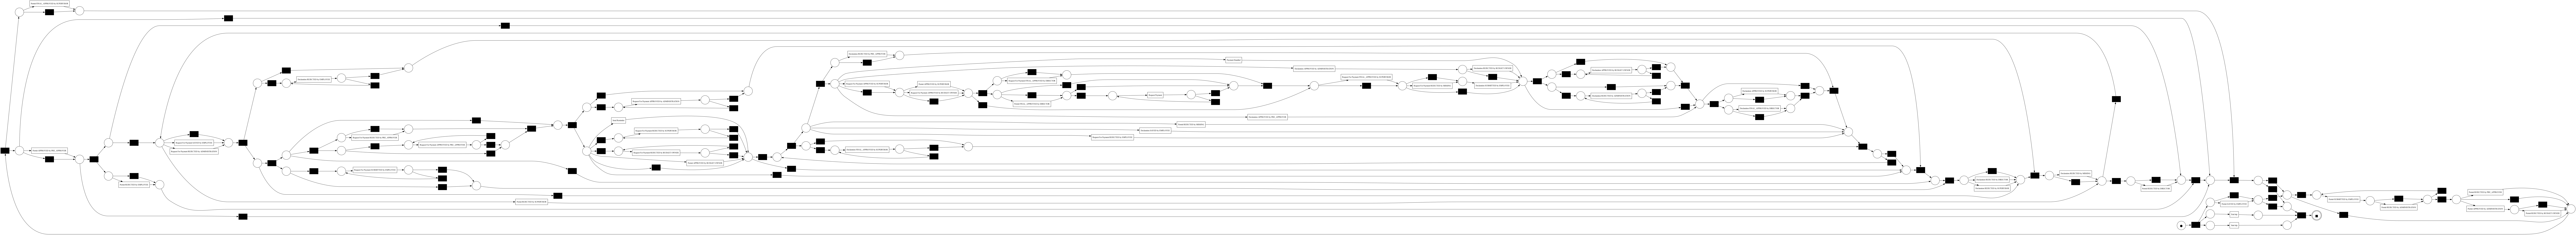

In [16]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Visualize the Petri net
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

#### Define Sliding Window

In [17]:
# Implement a sliding window approach to analyze the log in chunks
def sliding_window(data, window_size):
    """
    Generate chunks of the data using a sliding window approach.

    This function divides the input data into overlapping windows of a specified size. Each window
    is a subset of the data, allowing for sequential analysis in smaller, more manageable chunks.

    Parameters:
    data (iterable): The input data to be divided into windows.
    window_size (int): The size of each window (number of elements in each chunk).

    Yields:
    iterable: Subsequent windows (chunks) of the input data, each containing window_size elements.
    """
    for i in range(0, len(data) - window_size + 1):
        yield data[i:i + window_size]

window_size = 100  # Adjust based on your analysis
windows = list(sliding_window(sampled_df, window_size))

#### Conformance Checking
Conformance checking techniques compare a process model with an event log of the same process. The goal is to check if the event log conforms to the model, and, vice versa. (PM4py docs) </br>

The basic idea of **Inductive Miner** is about detecting a 'cut' in the log (e.g. sequential cut, parallel cut, concurrent cut and loop cut) and then recur on sublogs, which were found applying the cut, until a base case is found. The Directly-Follows variant avoids the recursion on the sublogs but uses the Directly Follows graph.

In [18]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as align

# Define the function to compute fitness
def compute_fitness(log, net, initial_marking, final_marking):
    """
    Compute the fitness of an event log with respect to a Petri net.

    This function evaluates how well the given event log conforms to the given Petri net by
    calculating the alignment between the event log and the Petri net. The fitness score is
    computed as the average fitness of all alignments.

    Parameters:
    log (pm4py.objects.log.obj.EventLog): The event log to be evaluated.
    net (pm4py.objects.petri.petrinet.PetriNet): The Petri net model.
    initial_marking (pm4py.objects.petri.petrinet.Marking): The initial marking of the Petri net.
    final_marking (pm4py.objects.petri.petrinet.Marking): The final marking of the Petri net.

    Returns:
    float: The fitness score of the event log with respect to the Petri net.
    """
    # Perform alignments between the event log and the Petri net
    alignments = align.apply(log, net, initial_marking, final_marking)
    
    # Calculate the fitness as the average fitness of all alignments
    fitness = sum(a['fitness'] for a in alignments) / len(alignments)
    
    return fitness

In [19]:
fitness_scores = []

for window in windows:
    # Convert the window to an event log
    window_log = pm4py.convert_to_event_log(window)

    # Compute the fitness for the current window
    fitness = compute_fitness(window_log, net, initial_marking, final_marking)
    fitness_scores.append(fitness)

# Print or analyze the fitness scores
print(fitness_scores)

aligning log, completed variants ::  33%|███▎      | 2/6 [00:29<00:58, 14.61s/it]

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

def detect_drifts(fitness_scores, threshold=0.05):
    changes = []
    X = np.arange(len(fitness_scores)).reshape(-1, 1)
    y = np.array(fitness_scores).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    slope = reg.coef_[0][0]
    if abs(slope) > threshold:
        changes.append(slope)
    return changes

fitness_scores = [compute_fitness(window, model) for window in windows]
drifts = detect_drifts(fitness_scores)
print("Detected drifts: ", drifts)